In [1]:
import torch

from src.data.project4.dataloader import get_loaders 
from src.models.project4.models import get_model
from src.utils import set_seed, get_optimizer
from src.models.project4.losses import get_loss

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from omegaconf import OmegaConf

In [2]:
torch.cuda.is_available()

True

In [3]:
args = OmegaConf.create({
    'model_name': 'efficientnet_b4',
    'region_size': 224,
    'batch_size': 1,
    'optimizer': 'Adam',
    'loss': 'BCE',
    'data_path': '/work3/s194253/02514/project4_results/data_wastedetection',
    'use_super_categories': True,
    'lr': 1e-04,
    'out': False,
    'seed': 0,
    'verbose': False,
    'percentage_to_freeze': None,
})

device = torch.device('cuda:0')
device = torch.device('cpu')

In [4]:
set_seed(args.seed)

In [5]:
# Get data loaders with applied transformations
loaders, num_classes = get_loaders(
    dataset='waste', 
    batch_size=args.batch_size, 
    seed=args.seed, 
    num_workers=1,
    img_size = (512, 512),
    region_size = (args.region_size, args.region_size),
    use_super_categories=args.use_super_categories,
    root = args.data_path,
)

id2cat_gt = loaders['train'].dataset.id2cat
# id2cat_test = loaders['test'].dataset.id2cat

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [6]:
idxs = """
  0: Can
  1: Carton
  2: Plastic glooves
  3: Aluminium foil
  4: Plastic container
  5: Lid
  6: Shoe
  7: Pop tab
  8: Food waste
  9: Bottle cap
  10: Broken glass
  11: Glass jar
  12: Battery
  13: Cup
  14: Squeezable tube
  15: Unlabeled litter
  16: Plastic utensils
  17: Styrofoam piece
  18: Straw
  19: Plastic bag & wrapper
  20: Blister pack
  21: Paper bag
  22: Paper
  23: Scrap metal
  24: Other plastic
  25: Bottle
  26: Cigarette
  27: Rope & strings
  28: Background"""

id2cat_ss = {int(line.split(': ')[0]): line.split(': ')[-1] for line in idxs.split('\n')[1:]}

In [7]:
loss_fun = get_loss(args.loss)
optimizer = get_optimizer(args.optimizer)

model = get_model(args.model_name, args, loss_fun, optimizer, out=args.out, num_classes=num_classes, region_size=(args.region_size, args.region_size), id2cat = id2cat_gt) #=loaders['train'].dataset.id2cat)

In [8]:
BASE_PATH = '/work3/s194253/02514/project4_results/logs/albertkjoller_efficientnet_crossentropy_resnet/resnet18/albertkjoller_efficientnet_crossentropy_resnet/resnet18/'
# BASE_PATH = '/work3/s194253/02514/project4_results/logs/albertkjoller_efficientnet_crossentropy_resnet_baseline/resnet18/albertkjoller_efficientnet_crossentropy_resnet_baseline/resnet18/'

VERSION = 0
EPOCH_NAME = 'epoch=9_loss_val=0.3782.ckpt' # 'epoch=19_loss_val=0.9569.ckpt'
# EPOCH_NAME = 'epoch=31_val_loss=0.0000.ckpt'

checkpoint_path = BASE_PATH + f'version_{VERSION}/checkpoints/' + EPOCH_NAME

# checkpoint_path = '/work3/s194253/02514/project4_results/models/albertkjoller_efficientnet_crossentropy_resnet_baseline/resnet18.ckpt'

model = model.load_from_checkpoint(checkpoint_path, loss_fun=loss_fun)
model.to(device)

model.eval()

print("Checkpoint loaded!")

Checkpoint loaded!


In [9]:
from src.utils import plot_SS
from torchvision.ops import box_iou, nms
from tqdm.notebook import tqdm
from collections import Counter

In [21]:
batch_idx = 210

batch = loaders['test'].dataset.__getitem__(batch_idx)

# for each image
i = 0
(img, cat_ids, bboxes_data, pred_bboxes_data) = batch

# for each bounding box
(bboxes, regions)           = bboxes_data # - not available at this point
(pred_bboxes, pred_regions) = pred_bboxes_data

# Classify proposed regions
y_hat = model.forward(pred_regions.to(device))

# maximum probabilities
outputs = torch.nn.functional.softmax(y_hat, dim=1)
pred_prob, pred_cat = torch.max(outputs, 1)

print("pred_cat:", pred_cat)

# # Applying NMS (remove redundant boxes)
"""
keep_indices = []
for cat in pred_cat.unique():
    # print(f"Doing NMS for {cat}\n Original indeces: {[pred_cat == cat]}")
    keep_indices += nms(pred_bboxes[pred_cat == cat].to(torch.float).to(device), pred_prob[pred_cat == cat], 0.5).cpu()
    # print(f"Found following indeces for {cat}: {nms(pred_bboxes[pred_cat == cat].to(torch.float).to(device), pred_prob[pred_cat == cat], 0.5).cpu()}")
keep_indices = torch.tensor(keep_indices)
"""

# # Applying NMS (remove redundant boxes)
keep_indices = []
indices_numbered = torch.arange(len(pred_cat))
for cat in pred_cat.unique():
    to_keep = nms(pred_bboxes[pred_cat == cat].to(torch.float).to(device), pred_prob[pred_cat == cat], 0.5).to(device)
    
    keep_indices += indices_numbered[pred_cat == cat][to_keep]
    
keep_indices = torch.tensor(keep_indices)

# Oroginal NMS
# keep_indices = nms(pred_bboxes.to(torch.float).to(device), pred_prob, 0.5).cpu()

# Computing AP

preds = {'boxes': pred_bboxes.cpu()[pred_cat.cpu() != max(id2cat_ss.keys())], 
        'scores': pred_prob.cpu()[pred_cat.cpu()   != max(id2cat_ss.keys())], 
        'labels': pred_cat.cpu()[pred_cat.cpu()    != max(id2cat_ss.keys())]} 


preds_NMS = {'boxes': pred_bboxes.cpu()[keep_indices][pred_cat.cpu()[keep_indices] != max(id2cat_ss.keys())], 
        'scores': pred_prob.cpu()[keep_indices][pred_cat.cpu()[keep_indices]   != max(id2cat_ss.keys())], 
        'labels': pred_cat.cpu()[keep_indices][pred_cat.cpu()[keep_indices]    != max(id2cat_ss.keys())]} 

targets = {
    'boxes':  bboxes, 
    'labels': cat_ids.flatten()
}


pred_cat: tensor([28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 19, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 19, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 19, 28, 28, 19, 28, 28, 28, 28, 28,
        28, 28, 19, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 19, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28])


In [22]:
Counter(pred_cat.numpy())

Counter({28: 97, 19: 6})

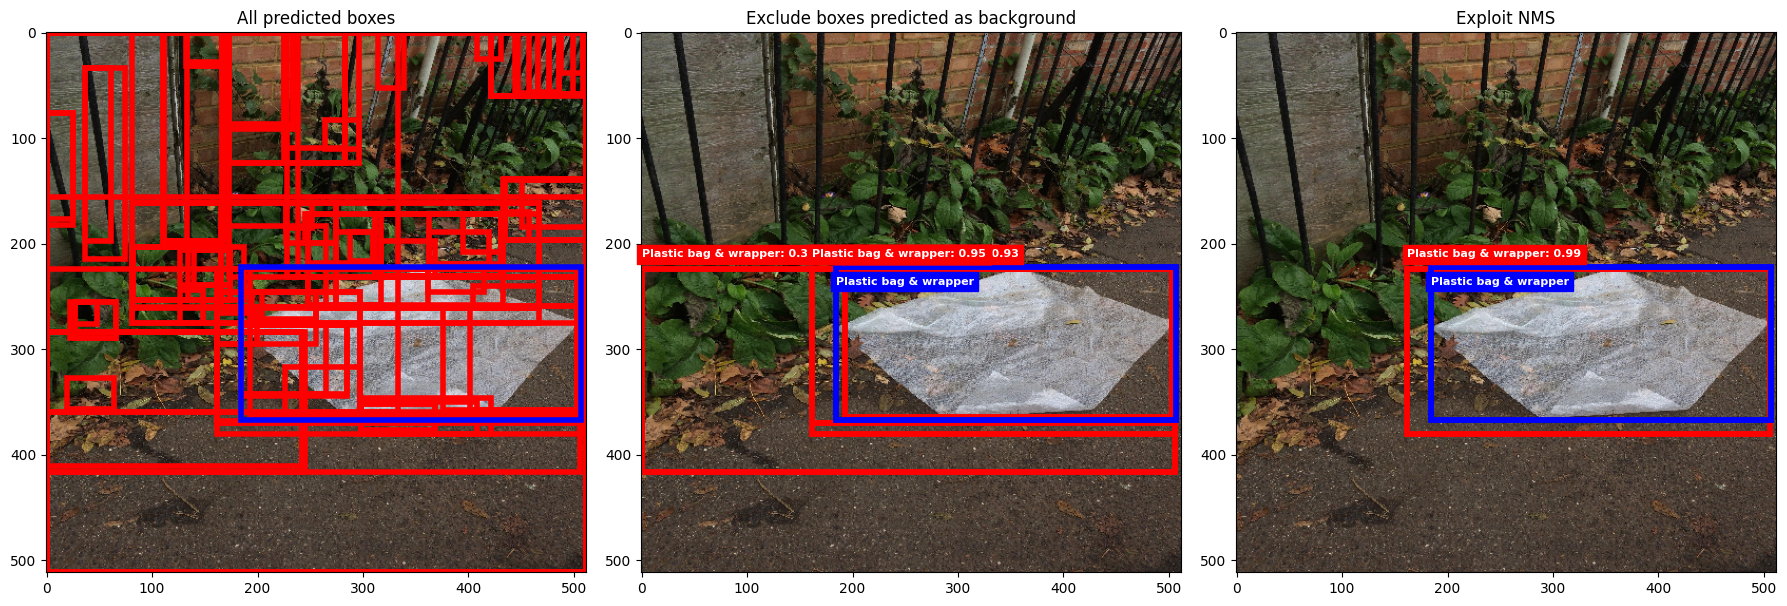

In [ ]:
plot_no_threshold = True

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(131)
ax.imshow(img.permute(1,2,0))
for i, bbox in enumerate(pred_bboxes):
    rect = patches.Rectangle(
        (bbox[0].item(), bbox[1].item()), 
        width=(bbox[2] - bbox[0]).item(), 
        height=(bbox[3] - bbox[1]).item(), 
        linewidth=4, 
        edgecolor=f"r", 
        facecolor='none'
    )
    ax.add_patch(rect)

for i, bbox in enumerate(targets['boxes']):
    rect = patches.Rectangle(
        (bbox[0].item(), bbox[1].item()), 
        width=(bbox[2] - bbox[0]).item(), 
        height=(bbox[3] - bbox[1]).item(), 
        linewidth=4, 
        edgecolor=f"b", 
        facecolor='none'
    )
    ax.add_patch(rect)
ax.set_title('All predicted boxes')
    
ax = fig.add_subplot(132)
ax.imshow(img.permute(1,2,0))
for i, bbox in enumerate(preds['boxes'][preds['labels'] != 28]):
    rect = patches.Rectangle(
        (bbox[0].item(), bbox[1].item()), 
        width=(bbox[2] - bbox[0]).item(), 
        height=(bbox[3] - bbox[1]).item(), 
        linewidth=4, 
        edgecolor=f"r", 
        facecolor='none'
    )
    ax.add_patch(rect)


    # Add the text inside the box
    ax.add_artist(rect)
    rx, ry = rect.get_xy()

    ax.annotate(f"{id2cat_ss[preds['labels'][i].item()]}: {preds['scores'][i].item():.2f}", (rx, ry-14), 
                backgroundcolor = 'r', color='w', weight='bold', 
            fontsize=8, ha='left', va='center')      
    

for i, bbox in enumerate(targets['boxes']):
    rect = patches.Rectangle(
        (bbox[0].item(), bbox[1].item()), 
        width=(bbox[2] - bbox[0]).item(), 
        height=(bbox[3] - bbox[1]).item(), 
        linewidth=4, 
        edgecolor=f"b", 
        facecolor='none'
    )
    ax.add_patch(rect)
    
    # Add the text inside the box
    ax.add_artist(rect)
    rx, ry = rect.get_xy()

    ax.annotate(f"{id2cat_gt[targets['labels'][i].item()]}", (rx, ry+14), backgroundcolor="b", color='w', 
                weight='bold', 
            fontsize=8, ha='left', va='center')   
    

ax.set_title('Exclude boxes predicted as background')

ax = fig.add_subplot(133)
ax.imshow(img.permute(1,2,0))
for i, bbox in enumerate(preds_NMS['boxes'][preds_NMS['labels'] != 28]):
    if preds['scores'][i] > 0.5 or plot_no_threshold:
        rect = patches.Rectangle(
            (bbox[0].item(), bbox[1].item()), 
            width=(bbox[2] - bbox[0]).item(), 
            height=(bbox[3] - bbox[1]).item(), 
            linewidth=4, 
            edgecolor=f"r", 
            facecolor='none'
        )
        ax.add_patch(rect)

        # Add the text inside the box
        ax.add_artist(rect)
        rx, ry = rect.get_xy()

        ax.annotate(f"{id2cat_ss[preds_NMS['labels'][i].item()]}: {preds_NMS['scores'][i].item():.2f}", (rx, ry-14), 
                    backgroundcolor = 'r', color='w', weight='bold', 
                fontsize=8, ha='left', va='center')        

for i, bbox in enumerate(targets['boxes']):
    rect = patches.Rectangle(
        (bbox[0].item(), bbox[1].item()), 
        width=(bbox[2] - bbox[0]).item(), 
        height=(bbox[3] - bbox[1]).item(), 
        linewidth=4, 
        edgecolor=f"b", 
        facecolor='none'
    )
    ax.add_patch(rect)
    
    # Add the text inside the box
    ax.add_artist(rect)
    rx, ry = rect.get_xy()

    ax.annotate(f"{id2cat_gt[targets['labels'][i].item()]}", (rx, ry+14), backgroundcolor="b", color='w', 
                weight='bold', 
            fontsize=8, ha='left', va='center')        
    
ax.set_title('Exploit NMS')

plt.tight_layout()
plt.savefig(f'/work3/s184984/02514/project4_results/predict_imgs/batch_idx{batch_idx}.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

In [13]:
pred_matches, gt_matches, box_labels, gt2pred = model.compare_boxes(bboxes, cat_ids, pred_bboxes, num_classes)